# MLP

Following https://www.youtube.com/watch?v=TCH_1BHY58I&t=188s

# Rebuilding Dataset ( -  00:12:00)

- load dataset
- build character-index lookup table
- build (xxx) -> y dataset (as tensors)


In [1]:
from pathlib import Path
import torch

In [2]:
names = Path('../data/names.txt').open().read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
characters = sorted(list(set(''.join(names))))
characters.insert(0, '.')

stoi = {c: i for i,c in enumerate(characters)}
itos = {i: c for c,i in stoi.items()}


In [4]:
from itertools import tee

def sliding_window(iterable, size):
    iters = tee(iterable, size)
    for i, it in enumerate(iters):
        for _ in range(i):
            next(it, None)
    return zip(*iters)


In [5]:
numbers = list(range(5))
for window in sliding_window(numbers, 3):
    print(window)

(0, 1, 2)
(1, 2, 3)
(2, 3, 4)


In [6]:
xs = []
ys = []
context_size = 3

for name in names[:5]:
    name = context_size*['.'] + list(name) + ['.']
    for chars in sliding_window(name, context_size+1):
        print(f'{chars[:context_size]} ---> {chars[-1]}')
        indices = list(map(lambda c: stoi[c], chars))
        xs.append((indices[:context_size]))
        ys.append(indices[-1])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

('.', '.', '.') ---> e
('.', '.', 'e') ---> m
('.', 'e', 'm') ---> m
('e', 'm', 'm') ---> a
('m', 'm', 'a') ---> .
('.', '.', '.') ---> o
('.', '.', 'o') ---> l
('.', 'o', 'l') ---> i
('o', 'l', 'i') ---> v
('l', 'i', 'v') ---> i
('i', 'v', 'i') ---> a
('v', 'i', 'a') ---> .
('.', '.', '.') ---> a
('.', '.', 'a') ---> v
('.', 'a', 'v') ---> a
('a', 'v', 'a') ---> .
('.', '.', '.') ---> i
('.', '.', 'i') ---> s
('.', 'i', 's') ---> a
('i', 's', 'a') ---> b
('s', 'a', 'b') ---> e
('a', 'b', 'e') ---> l
('b', 'e', 'l') ---> l
('e', 'l', 'l') ---> a
('l', 'l', 'a') ---> .
('.', '.', '.') ---> s
('.', '.', 's') ---> o
('.', 's', 'o') ---> p
('s', 'o', 'p') ---> h
('o', 'p', 'h') ---> i
('p', 'h', 'i') ---> a
('h', 'i', 'a') ---> .


In [7]:
xs.shape

torch.Size([32, 3])

# Embedding Matrix ( - 00:18:00)

- Create Embedding Matrix with embedding size 2 (for now)

In [8]:
C = torch.randn((27,2), requires_grad=True)

# Hidden Layer ( - 00:29:00)

- Hidden layer of dimension (6, 100)
    - weights and biases
- Transform input from (batch_size, 3, embedding_size) to (batch_size, 3*embedding_size) to enable multiplication
- activation function: tanh


In [9]:
X = C[xs]
X.shape

torch.Size([32, 3, 2])

In [10]:
W = torch.randn((6,100), requires_grad=True)
b = torch.randn((1, 100), requires_grad=True)

In [11]:
batch_size = X.shape[0]
reshaped = X.view(batch_size, -1)
reshaped.shape


torch.Size([32, 6])

In [12]:
((reshaped @ W) + b).shape

torch.Size([32, 100])

In [13]:
activation = torch.tanh((reshaped @ W) + b)

# Output layer ( - 00:33:00)

- from hidden_size(100) to 27 (amount of characters)
- neg. likelihood like last notebook

## Last layer

In [14]:
activation.shape

torch.Size([32, 100])

In [15]:
W2 = torch.randn((100,27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)


In [16]:
output = (activation @ W2) + b2
output.shape

torch.Size([32, 27])

## Loss

In [17]:
import torch.nn.functional as F

From the documentation of [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss):

- input has to be a Tensor of size $(C)$ for unbatched input, $(minibatch, C)$ for batched input
- The target should be class indices in the range $[0, C)$ where $C$ is the number of classes
- Reduction is by default 'mean'

In [18]:
print('Input shape: ', output.shape)
print('Target shape: ', ys.shape)
print('Target values: ', ys)

Input shape:  torch.Size([32, 27])
Target shape:  torch.Size([32])
Target values:  tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


In [19]:
F.cross_entropy(output, ys)

tensor(17.5627, grad_fn=<NllLossBackward0>)

Doing this by hand:

In [20]:
# softmax
counts = output.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

# neg log likelihood
logs = - probs.log()
loss = logs[torch.arange(len(ys)), ys]
loss.mean()

tensor(17.5627, grad_fn=<MeanBackward0>)

# Refactoring ( - 00:38:00)

- Define all matrices in one place
- collect parameters in list
    - count parameters, should be 3481
- Use seed generator
- define forward pass with F.cross_entropy()

In [21]:
context_size = 3
embedding_size = 2
hidden_layer_size = 100
lr = .1

#### Dataset

In [22]:
xs = []
ys = []

for name in names[:5]:
    name = context_size*['.'] + list(name) + ['.']
    for chars in sliding_window(name, context_size+1):
        indices = list(map(lambda c: stoi[c], chars))
        xs.append((indices[:context_size]))
        ys.append(indices[-1])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape

torch.Size([32, 3])

#### NN Setup

In [23]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  3481


#### Forward pass

In [24]:
embeddings = C[xs].view(-1, embedding_size*context_size)

inner = torch.tanh((embeddings @ W1) + b1)
logits = (inner @ W2) + b2

loss = F.cross_entropy(logits, ys)
loss.item()

17.769710540771484

# Training loop ( - 00:45:00)

- forward pass
- backward pass
    - zero grads
    - update by learning rate
- repeat n times for the one batch (intentional overfitting)
    - loss should go to ~.25 (1000 iterations)
- comnpare logits max against ys (manually)
    - should be close to actual indices

- Train on full dataset
    - slow
- instead use minibatches of size 32
    - randomly drawn in each iteration

#### Train loop

In [25]:
for epoch in range(1000):
    # forward pass
    embeddings = C[xs].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, ys)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= lr * param.grad

    if epoch%100==0:
        print(loss.item())

17.769710540771484
0.3354488015174866
0.278947651386261
0.2678886950016022
0.2631761431694031
0.26341554522514343
0.2601673901081085
0.2586156725883484
0.2575641870498657
0.256767600774765


#### Compare logits against indices

In [26]:
logits.max(dim=1)

torch.return_types.max(
values=tensor([13.3348, 17.7904, 20.6014, 20.6121, 16.7355, 13.3348, 15.9984, 14.1723,
        15.9146, 18.3614, 15.9395, 20.9265, 13.3348, 17.1090, 17.1319, 20.0601,
        13.3348, 16.5892, 15.1017, 17.0581, 18.5861, 15.9670, 10.8740, 10.6871,
        15.5056, 13.3348, 16.1794, 16.9743, 12.7426, 16.2009, 19.0845, 16.0195],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [27]:
ys

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

#### Train on full dataset

In [28]:
xs = []
ys = []

for name in names:
    name = context_size*['.'] + list(name) + ['.']
    for chars in sliding_window(name, context_size+1):
        indices = list(map(lambda c: stoi[c], chars))
        xs.append((indices[:context_size]))
        ys.append(indices[-1])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape

torch.Size([228146, 3])

In [29]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  3481


In [30]:
for epoch in range(10):
    # forward pass
    embeddings = C[xs].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, ys)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= lr * param.grad

    print(loss.item())

19.505229949951172
17.084491729736328
15.776533126831055
14.833340644836426
14.002601623535156
13.253255844116211
12.579915046691895
11.983098983764648
11.47049331665039
11.051857948303223


#### Minibatches

In [31]:
batch_size = 32

In [32]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  3481


In [33]:
lr = 1e-1

In [34]:
for epoch in range(1000):

    rand_idx = torch.multinomial(torch.ones(len(xs)), num_samples=batch_size, replacement=True)
    xb = xs[rand_idx]
    yb = ys[rand_idx]

    # forward pass
    embeddings = C[xb].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, yb)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= lr * param.grad

print(loss.item())

2.600525379180908


In [35]:
with torch.no_grad():
    embeddings = C[xs].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, ys)
    print(loss.item())

2.7048656940460205


# Learning Rate finder (  - 00:53:00)

- reset all parameters
- print loss for each batch
    - find too low lr
    - find too high lr
- generate log lrs between low and high end
- plot loss against lr
- choose lr at hockey stick point

In [36]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  3481


In [37]:
# too high: 10e2
# too low: 1e-3

lrs = torch.linspace(-3, 0, 100)
losses = []

for lr in lrs:

    rand_idx = torch.multinomial(torch.ones(len(xs)), num_samples=batch_size, replacement=True)
    xb = xs[rand_idx]
    yb = ys[rand_idx]

    # forward pass
    embeddings = C[xb].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, yb)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= (10**lr) * param.grad

    losses.append(loss.item())
    print(loss.item())

18.287813186645508
20.078800201416016
19.58531379699707
20.23301124572754
19.903757095336914
19.761646270751953
20.192344665527344
18.508893966674805
20.944576263427734
21.88829803466797
18.51089096069336
19.69101905822754
20.15926742553711
21.151819229125977
18.209585189819336
14.59067153930664
17.247766494750977
19.628311157226562
20.763717651367188
19.88680076599121
16.581565856933594
21.0137882232666
20.341217041015625
18.980661392211914
19.615192413330078
18.46270179748535
16.90849494934082
16.436506271362305
15.971134185791016
18.259035110473633
17.835163116455078
18.386056900024414
17.41419219970703
18.95256233215332
13.030254364013672
16.008800506591797
17.777196884155273
13.649407386779785
16.71481704711914
14.819585800170898
13.505420684814453
15.487156867980957
16.9182186126709
18.313085556030273
15.177300453186035
12.391192436218262
16.21954917907715
14.825508117675781
16.22516441345215
13.889214515686035
15.282487869262695
15.66090202331543
16.259502410888672
13.8636388778

In [38]:
import matplotlib.pyplot as plt

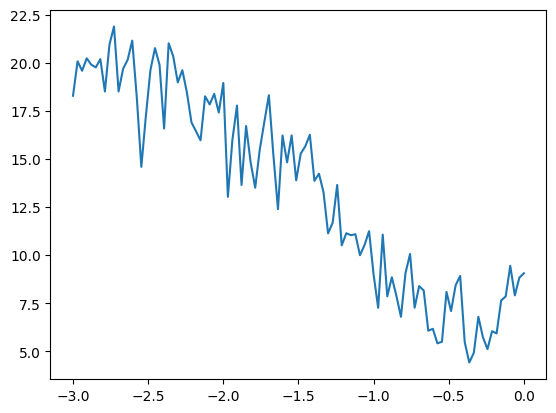

In [39]:
fix, ax = plt.subplots()

ax.plot(lrs, losses)

plt.show()

# Overfitting

- split into training/dev/test set
  - e.g. $80\%$ / $10\%$ / $10\%$
  - train: tune parameters
  - dev: hyperparameters
  - test: actual model performance. Evaluate only sparingly, as every evaluation makes overfitting more likely
- shuffle all words with seed 42 (with python random)
- take first $80\%$ for train, next $10\%$ for dev


In [43]:
import random

def build_dataset(words):
    xs = []
    ys = []
    context_size = 3

    for word in words:
        word = context_size*['.'] + list(word) + ['.']
        for chars in sliding_window(word, context_size+1):
            indices = list(map(lambda c: stoi[c], chars))
            xs.append((indices[:context_size]))
            ys.append(indices[-1])

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)

    return xs, ys
    



random.shuffle(names)
xs, ys = build_dataset(names)

train_id = int(.8*len(xs))
dev_id = int(.9*len(xs))

train_x = xs[:train_id]
dev_x = xs[train_id:dev_id]
test_x = xs[:dev_id]

train_y = ys[:train_id]
dev_y = ys[train_id:dev_id]
test_y = ys[:dev_id]

- evaluate
  - train on train set
  - evaluate on dev set
  - 30k iterations, should be roughly equal loss

In [54]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

lr = .1
print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  3481


In [55]:
%%time
for epoch in range(30000):
    rand_idx = torch.multinomial(torch.ones(len(train_x)), num_samples=batch_size, replacement=True)
    xb = train_x[rand_idx]
    yb = ys[rand_idx]

    # forward pass
    embeddings = C[xb].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, yb)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= lr * param.grad

print(loss.item())

2.6478586196899414
CPU times: total: 4min 33s
Wall time: 34.3 s


In [56]:
def eval_model(x, y):
    with torch.no_grad():
        embeddings = C[x].view(-1, embedding_size*context_size)

        inner = torch.tanh((embeddings @ W1) + b1)
        logits = (inner @ W2) + b2

        loss = F.cross_entropy(logits, y)
        return loss.item()

In [57]:
print('Train:', eval_model(train_x, train_y))
print('Dev:', eval_model(dev_x, dev_y)
)

2.4237067699432373

2.4409539699554443

- Overfitting can't really happen right now, because model is too small
- make model larger
  - increase hidden layer size to $300$
  - plot loss over steps
    - very noisy
  - decrease learning rate
  - retrain until loss is smaller than with smaller model


In [68]:
hidden_layer_size = 300

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

lr = .1
print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  10281


In [69]:
%%time
losses = []
steps = []

for epoch in range(30000):
    rand_idx = torch.multinomial(torch.ones(len(train_x)), num_samples=batch_size, replacement=True)
    xb = train_x[rand_idx]
    yb = ys[rand_idx]

    # forward pass
    embeddings = C[xb].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, yb)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= lr * param.grad

    # losses.append(loss.item())
    # steps.append(epoch)

print(loss.item())

2.4313488006591797
CPU times: total: 4min 38s
Wall time: 35 s


In [70]:
print('Train:', eval_model(train_x, train_y))
print('Dev:', eval_model(dev_x, dev_y))

Train: 2.4586215019226074
Dev: 2.469517469406128


- visualize character embeddings


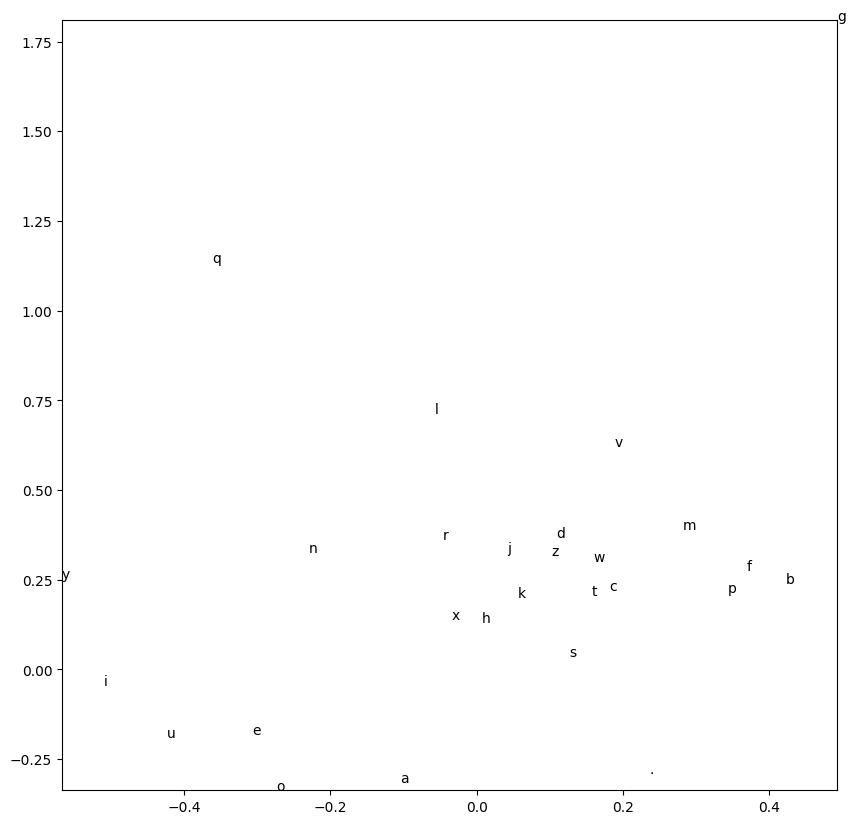

In [77]:
fig, ax = plt.subplots(figsize=(10,10))

for e,(x,y) in enumerate(C):
    ax.text(x.item(), y.item(), itos[e])

ax.set_xlim(C[:,0].min().item(), C[:,0].max().item())
ax.set_ylim(C[:,1].min().item(), C[:,1].max().item())

plt.show()

- increase net once again:
  - emb_size=10
  - decrease hidden from 300 to 200


In [84]:
hidden_layer_size = 200
embedding_size = 10

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

lr = .1
print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  11897


In [85]:
%%time
losses = []
steps = []

for epoch in range(10000):
    rand_idx = torch.multinomial(torch.ones(len(train_x)), num_samples=batch_size, replacement=True)
    xb = train_x[rand_idx]
    yb = ys[rand_idx]

    # forward pass
    embeddings = C[xb].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, yb)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= lr * param.grad

    losses.append(loss.log().item())
    steps.append(epoch)

print(loss.item())

1.9979248046875
CPU times: total: 1min 35s
Wall time: 12 s


In [91]:
rand_idx

tensor([ 87885, 135438,  18476, 135317, 112801, 154243,  10366,   9638, 130695,
        141240, 118686, 162416, 138397, 163494,  60332,  18763, 122442, 128684,
        101016, 180482,   2011, 114459, 169345,  25282, 101481, 113637, 115350,
        150518, 126101,  24732,   9312,  96688])

In [95]:
torch.multinomial(torch.ones(len(train_x)), num_samples=batch_size, replacement=True)

tensor([ 58994,  64701, 128780,  80599,   9033,  34485,   5573,  87268,  77846,
         75323,  42094,  98273, 122997,  75430,  34032,  12281,  41181,  38901,
        135048, 127500,  40841, 140879,   1959, 181016,   1799, 158208, 153011,
         24508,  38436,  60981, 156434,  58295])

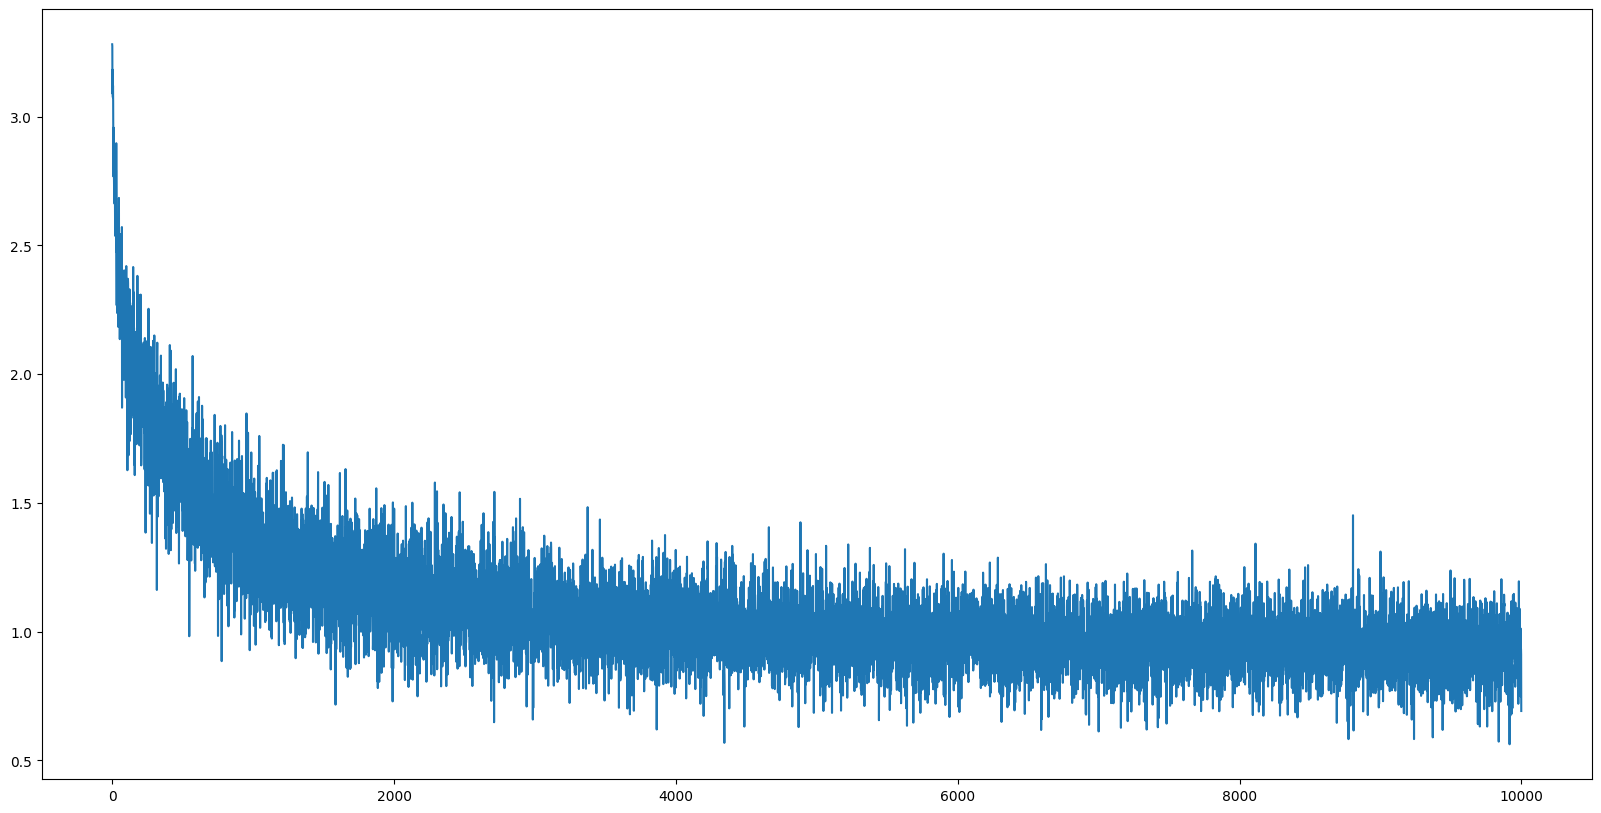

In [86]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(steps, losses)
plt.show()

In [88]:
embeddings = C[train_x].view(-1, embedding_size*context_size)

inner = torch.tanh((embeddings @ W1) + b1)
logits = (inner @ W2) + b2

loss = F.cross_entropy(logits, train_y)
loss.item()

2.55918025970459

In [89]:
print('Train:', eval_model(xb, yb))
print('Dev:', eval_model(dev_x, dev_y))

Train: 1.4230238199234009
Dev: 2.578944206237793


- plot log-loss over steps
- sample from the model
- read the [original paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)